# Capstone project - New York City & Toronto Neighbourhoods Clustering

In [158]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import folium # map rendering library
from IPython.display import HTML
import seaborn as sns
import time

## New York City data loading

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [3]:
with open(r"newyork_data.json") as json_data:
    newyork_data = json.load(json_data)

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [5]:
NYC_Neighbourhoods_data = newyork_data['features']
NYC_Neighbourhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Transform the data into a pandas dataframe

In [6]:
NYC_neighborhoods = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude'])

In [7]:
for data in NYC_Neighbourhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NYC_neighborhoods = NYC_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
NYC_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
print(len(NYC_neighborhoods))

306


In [10]:
print(f"The dataframe has {len(NYC_neighborhoods['Borough'].unique())} boroughs and {len(NYC_neighborhoods)} neighbourhoods")

The dataframe has 5 boroughs and 306 neighbourhoods


### check to see if the neighborhoods' name in different boroughs are unique or not

In [11]:
neighborhoods_unique_names = NYC_neighborhoods['Neighborhood'].value_counts()
neighborhoods_unique_names

Murray Hill                  2
Bay Terrace                  2
Sunnyside                    2
Chelsea                      2
Douglaston                   1
Arden Heights                1
Tudor City                   1
New Dorp                     1
Mill Basin                   1
Clinton Hill                 1
Chinatown                    1
Olinville                    1
Greenridge                   1
Broadway Junction            1
Prospect Park South          1
Blissville                   1
Holliswood                   1
Dumbo                        1
Arverne                      1
Brownsville                  1
Stuyvesant Town              1
Pelham Bay                   1
Lefrak City                  1
Pelham Parkway               1
Flatlands                    1
Oakwood                      1
Bronxdale                    1
Travis                       1
Great Kills                  1
Sea Gate                     1
Ditmas Park                  1
Charleston                   1
South Oz

In [12]:
nonunique_neighborhoods_names =  neighborhoods_unique_names[neighborhoods_unique_names > 1]
nonunique_neighborhoods_names

Murray Hill    2
Bay Terrace    2
Sunnyside      2
Chelsea        2
Name: Neighborhood, dtype: int64

In [13]:
NYC_neighborhoods[NYC_neighborhoods['Neighborhood'] == 'Murray Hill']

,Borough,Neighborhood,Latitude,Longitude
115,Manhattan,Murray Hill,40.748303,-73.978332
180,Queens,Murray Hill,40.764126,-73.812763


In [14]:
for name in nonunique_neighborhoods_names.items():
    for i in range(len(NYC_neighborhoods)):
        if (NYC_neighborhoods.loc[i, 'Neighborhood']) == name[0]:
            NYC_neighborhoods.loc[i, 'Neighborhood'] = f"{name[0]} - {NYC_neighborhoods.loc[i, 'Borough']}"

In [15]:
NYC_neighborhoods[NYC_neighborhoods['Neighborhood'].str.contains('-', regex=False)]

,Borough,Neighborhood,Latitude,Longitude
1,Bronx,Co-op City,40.874294,-73.829939
115,Manhattan,Murray Hill - Manhattan,40.748303,-73.978332
116,Manhattan,Chelsea - Manhattan,40.744035,-74.003116
140,Queens,Sunnyside - Queens,40.740176,-73.926916
175,Queens,Bay Terrace - Queens,40.782843,-73.776802
180,Queens,Murray Hill - Queens,40.764126,-73.812763
220,Staten Island,Sunnyside - Staten Island,40.612760,-74.097126
235,Staten Island,Bay Terrace - Staten Island,40.553988,-74.139166
244,Staten Island,Chelsea - Staten Island,40.594726,-74.189560


### get the latitude & longitude of New York City

In [16]:
NYC_address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
NYC_location = geolocator.geocode(NYC_address)
NYC_latitude = NYC_location.latitude
NYC_longitude = NYC_location.longitude
print(f'The geograpical coordinate of New York City are {NYC_latitude}, {NYC_longitude}.')

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### calculation of radius for each neighborhood & add them to the dataframe

In [17]:
from math import cos, asin, sqrt, pi

In [18]:
# function to calculate distance (km) between two latitude-longitude points
def calcDistance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

In [19]:
def findOptimumRadii(neighborhood_df):
    optimumRadii = []
    distances = []
    for i in range(len(neighborhood_df)):
        for j in range(len(neighborhood_df)):
                distance = calcDistance(neighborhood_df.loc[i, 'Latitude'], neighborhood_df.loc[i, 'Longitude'], neighborhood_df.loc[j, 'Latitude'], neighborhood_df.loc[j, 'Longitude'])
                distances.append(distance * 1000)
                if (j == len(neighborhood_df)-1):
                    distances.remove(0)
                    minRadius = min(distances)/2
                    optimumRadii.append(minRadius)
                    distances.clear()
    return optimumRadii
        

In [20]:
NYC_neighborhoods['Radius'] = findOptimumRadii(NYC_neighborhoods)

In [21]:
NYC_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude,Radius
0,Bronx,Wakefield,40.894705,-73.847201,565.191216
1,Bronx,Co-op City,40.874294,-73.829939,481.235842
2,Bronx,Eastchester,40.887556,-73.827806,742.734963
3,Bronx,Fieldston,40.895437,-73.905643,388.116468
4,Bronx,Riverdale,40.890834,-73.912585,388.116468


### map of New York City with neighborhoods superimposed on top

In [22]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[NYC_latitude, NYC_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, radius in zip(NYC_neighborhoods['Latitude'], NYC_neighborhoods['Longitude'], NYC_neighborhoods['Borough'], NYC_neighborhoods['Neighborhood'], NYC_neighborhoods['Radius']):
    label = f'{neighborhood}, {borough}'
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=radius,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Retrieving venues data for New York City

In [23]:
# Foursquare API credentials
CLIENT_ID = 'ADMBEOX5DBDY0ABNHHQRWVQ0B3S3Z1FXX0DDBH4X0N5LLWG3' # your Foursquare ID
CLIENT_SECRET = '1TFMWMXQPATEOHFV40CCS5DRF45YO34INLS4UTYZNMIVTD31' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### get the nearby venues for each of the neighborhoods in New York city

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radii):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radii):        
            
        # create the API request URL
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={LIMIT}'
 
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
              'Neighborhood Latitude', 
              'Neighborhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
    
    # return a list of neighborhoods (each neighborhoods data in a list), each list contains the nearby veunes for that neighborhood 
    #  ---> [[nearby venues for neighborhood 1], [nearby venues for neighborhood 2], ...]
    return(nearby_venues) 

In [25]:
nyc_venues = getNearbyVenues(names=NYC_neighborhoods['Neighborhood'],
                                   latitudes=NYC_neighborhoods['Latitude'],
                                   longitudes=NYC_neighborhoods['Longitude'],
                                   radii=NYC_neighborhoods['Radius']
                                  )

In [26]:
print(nyc_venues.shape)
nyc_venues.head()

(10086, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [27]:
nyc_venues['Venue Category'].unique()

array(['Dessert Shop', 'Pharmacy', 'Ice Cream Shop', 'Donut Shop',
       'Mobile Phone Shop', 'Sandwich Place', 'Deli / Bodega',
       'Laundromat', 'Pizza Place', 'Discount Store', 'Post Office',
       'Bagel Shop', 'Grocery Store', 'Fast Food Restaurant',
       'Restaurant', 'Bus Station', 'Baseball Field',
       'Chinese Restaurant', 'Liquor Store', 'Salon / Barbershop',
       'Trail', 'Park', 'Diner', 'Caribbean Restaurant',
       'Seafood Restaurant', 'Furniture / Home Store', 'Burger Joint',
       'Shopping Mall', 'Nightclub', 'Bowling Alley', 'Cocktail Bar',
       'Asian Restaurant', "Women's Store", 'Department Store',
       'Automotive Shop', 'Food & Drink Shop', 'Cosmetics Shop',
       'Sporting Goods Shop', 'Plaza', 'River', 'Playground',
       'Farmers Market', 'Gourmet Shop', 'Latin American Restaurant',
       'Beer Bar', 'Warehouse Store', 'Pub', 'Spanish Restaurant',
       'Coffee Shop', 'Mexican Restaurant', 'Thrift / Vintage Store',
       'Wings Joint', 

In [28]:
nyc_venues = nyc_venues[~nyc_venues['Venue Category'].isin(['Metro Station', 'Bus Stop', 'Bus Line', 'Train Station', 'Gas Station'
, 'Neighborhood', 'Field', 'Bridge', 'Office', 'Train', 'Platform'])]
print(nyc_venues.shape)

(9920, 7)


In [29]:
nyc_venues = nyc_venues[~nyc_venues['Venue Category'].isin(['Church', 'River'])]
print(nyc_venues.shape)

(9915, 7)


### how many venues were returned for each neighborhood

In [30]:
nyc_venues.groupby(['Neighborhood']).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,20,20,20,20,20,20
Annadale,12,12,12,12,12,12
Arden Heights,5,5,5,5,5,5
Arlington,4,4,4,4,4,4
Arrochar,12,12,12,12,12,12
Arverne,18,18,18,18,18,18
Astoria,100,100,100,100,100,100
Astoria Heights,13,13,13,13,13,13
Auburndale,69,69,69,69,69,69


In [31]:
print(f"number of neighborhoods in NYC_neighborhoods is {len(NYC_neighborhoods)} and the number of neighborhoods in venue table is {len(nyc_venues.groupby(['Neighborhood']).count())}")

number of neighborhoods in NYC_neighborhoods is 306 and the number of neighborhoods in venue table is 302


so Foursquare API did not return venues for four neighborhoods, which are:

In [32]:
set(NYC_neighborhoods['Neighborhood']).difference(nyc_venues['Neighborhood'])

{'Ditmas Park', 'Grymes Hill', 'Heartland Village', 'Paerdegat Basin'}

In [458]:
nyc_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


### Number of unique venues categories returned from Foursquare API

In [459]:
print(f"There are {len(nyc_venues['Venue Category'].unique())} unique categories returned from API for NYC")

There are 427 unique categories returned from API for NYC


## Toronto data loading
## --------------------------------------------------------------------------------------------------------------------------------

In [35]:
res = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

In [36]:
print(f'type of response: {type(res)} and it has a length of {len(res)}')

type of response: <class 'list'> and it has a length of 3


In [37]:
toronto_neighborhoods = res[0]

In [38]:
toronto_neighborhoods.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [39]:
toronto_neighborhoods.shape

(180, 3)

### removing the rows where Borough is 'Not assigned'

In [40]:
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods['Borough'] != 'Not assigned'].reset_index(drop=True)
toronto_neighborhoods.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [41]:
toronto_neighborhoods.shape

(103, 3)

In [42]:
toronto_neighborhoods[toronto_neighborhoods['Neighbourhood'] == 'Not assigned']

,Postal Code,Borough,Neighbourhood


### adding latitude & longitude to the toronto_neighborhoods dataframe

In [43]:
torontoPotalCodeCoordinates = pd.read_csv('https://cocl.us/Geospatial_data')
torontoPotalCodeCoordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [44]:
torontoPotalCodeCoordinates.shape

(103, 3)

In [45]:
toronto_neighborhoods['Latitude'] = np.nan
toronto_neighborhoods['Longitude'] = np.nan

In [46]:
len1 = len(toronto_neighborhoods)
len2 = len(torontoPotalCodeCoordinates)
for i in range(len1):
    for j in range(len2):
        if (toronto_neighborhoods.loc[i,'Postal Code'] == torontoPotalCodeCoordinates.loc[j, 'Postal Code']):
            toronto_neighborhoods.loc[i,'Latitude'] = torontoPotalCodeCoordinates.loc[j, 'Latitude']
            toronto_neighborhoods.loc[i,'Longitude'] = torontoPotalCodeCoordinates.loc[j, 'Longitude']

In [47]:
toronto_neighborhoods.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [48]:
toronto_neighborhoods.shape

(103, 5)

### check to see if the neighbothoods names are unique

In [49]:
to_neighborhoods_unique_names = toronto_neighborhoods['Neighbourhood'].value_counts()

In [50]:
to_neighborhoods_unique_names[to_neighborhoods_unique_names>1]

Downsview    4
Don Mills    2
Name: Neighbourhood, dtype: int64

In [51]:
toronto_neighborhoods[(toronto_neighborhoods['Neighbourhood'] == 'Downsview') | (toronto_neighborhoods['Neighbourhood'] =='Don Mills')]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
7,M3B,North York,Don Mills,43.745906,-79.352188
13,M3C,North York,Don Mills,43.725900,-79.340923
40,M3K,North York,Downsview,43.737473,-79.464763
46,M3L,North York,Downsview,43.739015,-79.506944
53,M3M,North York,Downsview,43.728496,-79.495697
60,M3N,North York,Downsview,43.761631,-79.520999


#### there are different postal codes for the same neighbourhood and borough. To deal with this, we can add the postal code to the end of the neighbourhood's name

In [52]:
for i in range(len(toronto_neighborhoods)):
    if ((toronto_neighborhoods.loc[i, 'Neighbourhood'] == 'Downsview') | (toronto_neighborhoods.loc[i, 'Neighbourhood'] == 'Don Mills')):
        toronto_neighborhoods.loc[i, 'Neighbourhood'] = f"{toronto_neighborhoods.loc[i, 'Neighbourhood']} - {toronto_neighborhoods.loc[i, 'Postal Code']}"

In [53]:
toro_neighborhoods_unique_names = toronto_neighborhoods['Neighbourhood'].value_counts()
toro_neighborhoods_unique_names[toro_neighborhoods_unique_names>1]

Series([], Name: Neighbourhood, dtype: int64)

In [54]:
toronto_neighborhoods[(toronto_neighborhoods['Neighbourhood'].str.contains('Downsview -', regex=False)) | (toronto_neighborhoods['Neighbourhood'].str.contains('Don Mills -', regex=False))]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
7,M3B,North York,Don Mills - M3B,43.745906,-79.352188
13,M3C,North York,Don Mills - M3C,43.725900,-79.340923
40,M3K,North York,Downsview - M3K,43.737473,-79.464763
46,M3L,North York,Downsview - M3L,43.739015,-79.506944
53,M3M,North York,Downsview - M3M,43.728496,-79.495697
60,M3N,North York,Downsview - M3N,43.761631,-79.520999


In [55]:
toronto_neighborhoods.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)

In [56]:
toronto_neighborhoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [57]:
toronto_neighborhoods.shape

(103, 5)

### latitude & longitude of Toronto

In [58]:
TO_address = 'Toronto, TO'

geolocator = Nominatim(user_agent="to_explorer")
TO_location = geolocator.geocode(TO_address)
TO_latitude = TO_location.latitude
TO_longitude = TO_location.longitude
print(f'The geograpical coordinate of Toronto City are {TO_latitude}, {TO_longitude}.')

The geograpical coordinate of Toronto City are 43.65238435, -79.38356765.


### calculation of radius for each neighborhood and add them to the dataframe

In [59]:
toronto_neighborhoods['Radius'] = findOptimumRadii(toronto_neighborhoods)

In [60]:
toronto_neighborhoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Radius
0,M3A,North York,Parkwoods,43.753259,-79.329656,992.961518
1,M4A,North York,Victoria Village,43.725882,-79.315572,1018.563373
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,614.195007
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,934.471639
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,256.276246


### Map of Toronto with neighbourhoods superimposed on top

In [61]:
map_toronto = folium.Map(location=[TO_latitude, TO_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, radius in zip(toronto_neighborhoods['Latitude'], toronto_neighborhoods['Longitude'], toronto_neighborhoods['Borough'], toronto_neighborhoods['Neighborhood'], toronto_neighborhoods['Radius']):
    label = f'{neighborhood}, {borough}'
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=radius,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### get nearby venues for the neighborhoods in Toronto

In [62]:
toronto_venues = getNearbyVenues(names=toronto_neighborhoods['Neighborhood'],
                                   latitudes=toronto_neighborhoods['Latitude'],
                                   longitudes=toronto_neighborhoods['Longitude'],
                                   radii=toronto_neighborhoods['Radius'])

In [63]:
print(toronto_venues.shape)
toronto_venues.head()

(3282, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
2,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
3,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store
4,Parkwoods,43.753259,-79.329656,High Street Fish & Chips,43.745260,-79.324949,Fish & Chips Shop


In [64]:
toronto_venues = toronto_venues[~toronto_venues['Venue Category'].isin(['Metro Station', 'Bus Stop', 'Bus Line', 'Train Station', 'Gas Station'
, 'Neighborhood', 'Field', 'Bridge', 'Office', 'Train', 'Platform', 'Church', 'River'])]
print(toronto_venues.shape)

(3207, 7)


### how many venues were returned for each neighborhood in Toronto

In [65]:
toronto_venues.groupby(['Neighborhood']).count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,61,61,61,61,61,61
"Alderwood, Long Branch",66,66,66,66,66,66
"Bathurst Manor, Wilson Heights, Downsview North",37,37,37,37,37,37
Bayview Village,13,13,13,13,13,13
"Bedford Park, Lawrence Manor East",46,46,46,46,46,46
"Birch Cliff, Cliffside West",13,13,13,13,13,13
"Brockton, Parkdale Village, Exhibition Place",67,67,67,67,67,67
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",14,14,14,14,14,14
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",31,31,31,31,31,31


In [66]:
print(f"number of neighborhoods in toronto_neighborhoods is {len(toronto_neighborhoods)} and the number of neighborhoods in venue table is {len(toronto_venues.groupby(['Neighborhood']).count())}")

number of neighborhoods in toronto_neighborhoods is 103 and the number of neighborhoods in venue table is 102


 so Foursquare API did not return venues for one neighborhoods, which is:

In [67]:
set(toronto_neighborhoods['Neighborhood']).difference(toronto_venues['Neighborhood'])

{'Berczy Park'}

### number of unique venue categories returned from API for neighborhoods in Toronto

In [68]:
print(f"There are {len(toronto_venues['Venue Category'].unique())} unique categories returned from API for Toronto")

There are 313 unique categories returned from API for Toronto


## Exploratory Data Analysis
## ---------------------------------------------------------------------------------------------------------------------------------

### New York Venues dataframe (nyc_venues)

In [69]:
nyc_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


### Number of venues per neighborhood (NYC)

In [70]:
# create a dataframe containing neighbourhood names, number of returned venues for that neighbourhood and the distance assigned to it
def cityVenuesNumberPerHoodDf(neighborhoodDf, venuesDf):
    venues_per_hood =  pd.DataFrame(columns=['Neighborhood', 'Number of Venues', 'Distance'])
    venues_per_hood['Neighborhood'] = venuesDf.groupby(['Neighborhood']).count().reset_index()['Neighborhood']
    venues_per_hood['Number of Venues'] = venuesDf.groupby(['Neighborhood']).count().reset_index()['Venue']
    
    for i in range(len(venues_per_hood)):
        for j in range(len(neighborhoodDf)):
            if (venues_per_hood.loc[i, 'Neighborhood'] == neighborhoodDf.loc[j, 'Neighborhood']):
                venues_per_hood.loc[i, 'Distance'] = neighborhoodDf.loc[j, 'Radius'] * 2
                
    return venues_per_hood

In [71]:
nyc_venues_per_hood = cityVenuesNumberPerHoodDf(NYC_neighborhoods, nyc_venues)
nyc_venues_per_hood.head()

,Neighborhood,Number of Venues,Distance
0,Allerton,20,706.253
1,Annadale,12,1285.69
2,Arden Heights,5,1388.38
3,Arlington,4,939.661
4,Arrochar,12,835.184


In [72]:
nyc_venues_per_hood['Number of Venues'].describe()

count    302.000000
mean      32.831126
std       29.667615
min        1.000000
25%        9.250000
50%       22.000000
75%       46.750000
max      100.000000
Name: Number of Venues, dtype: float64

Text(0.5, 1.0, 'Frequency distribution of the number of venues ')

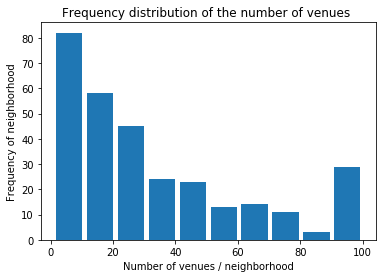

In [73]:
plt.hist(nyc_venues_per_hood['Number of Venues'], rwidth=0.85)
plt.xlabel('Number of venues / neighborhood')
plt.ylabel('Frequency of neighborhood')
plt.title('Frequency distribution of the number of venues ')

#### Given that each neighborhood has a different radius passed to the venues request, it's better to represent the venues per neighborhood in terms of density, that's venues per area cover for each neighborhood, in this case the area cover in the venues search defined by the distance to the closest postcode (Distance in nyc_venues_per_hood dataframe).

In [74]:
import math
from matplotlib.ticker import PercentFormatter

In [104]:
# Density unit: number of venues/ distance (km)
nyc_venues_per_hood['Density'] = np.floor(nyc_venues_per_hood['Number of Venues'] / (nyc_venues_per_hood['Distance'] * 0.001)).astype(float)
nyc_venues_per_hood.head()

,Neighborhood,Number of Venues,Distance,Density
0,Allerton,20,706.253,28.0
1,Annadale,12,1285.69,9.0
2,Arden Heights,5,1388.38,3.0
3,Arlington,4,939.661,4.0
4,Arrochar,12,835.184,14.0


In [106]:
nyc_venues_per_hood['Density'].describe()

count    302.000000
mean      31.546358
std       31.220194
min        0.000000
25%       10.000000
50%       20.000000
75%       42.000000
max      176.000000
Name: Density, dtype: float64

<class 'numpy.ndarray'>


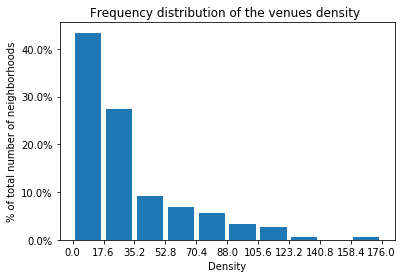

In [113]:
n, bins, patches = plt.hist(nyc_venues_per_hood['Density'], rwidth=0.85, weights=np.ones(len(nyc_venues_per_hood)) / len(nyc_venues_per_hood))
plt.xticks(bins.tolist())
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
print(type(bins))
plt.xlabel('Density')
plt.ylabel('% of total number of neighborhoods')
plt.title('Frequency distribution of the venues density ')
plt.show()

### Toronto Venues dataframe (toronto_venues)

In [92]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
2,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
3,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store
4,Parkwoods,43.753259,-79.329656,High Street Fish & Chips,43.745260,-79.324949,Fish & Chips Shop


### Number of venues per neighborhood

In [93]:
toronto_venues_per_hood = cityVenuesNumberPerHoodDf(toronto_neighborhoods, toronto_venues)
toronto_venues_per_hood.head()

,Neighborhood,Number of Venues,Distance
0,Agincourt,61,2958.68
1,"Alderwood, Long Branch",66,3413.93
2,"Bathurst Manor, Wilson Heights, Downsview North",37,2603.93
3,Bayview Village,13,1822.66
4,"Bedford Park, Lawrence Manor East",46,2289.06


In [108]:
toronto_venues_per_hood['Number of Venues'].describe()

count    102.000000
mean      31.441176
std       24.340234
min        3.000000
25%       13.000000
50%       26.000000
75%       42.000000
max      100.000000
Name: Number of Venues, dtype: float64

In [109]:
# Density unit: number of venues/ distance (km)
toronto_venues_per_hood['Density'] = np.floor(toronto_venues_per_hood['Number of Venues'] / (toronto_venues_per_hood['Distance'] * 0.001)).astype(float)
toronto_venues_per_hood.head()

,Neighborhood,Number of Venues,Distance,Density
0,Agincourt,61,2958.68,20.0
1,"Alderwood, Long Branch",66,3413.93,19.0
2,"Bathurst Manor, Wilson Heights, Downsview North",37,2603.93,14.0
3,Bayview Village,13,1822.66,7.0
4,"Bedford Park, Lawrence Manor East",46,2289.06,20.0


In [110]:
toronto_venues_per_hood['Density'].describe()

count    102.000000
mean      21.990196
std       22.698844
min        1.000000
25%        7.000000
50%       14.000000
75%       28.500000
max      132.000000
Name: Density, dtype: float64

<class 'numpy.ndarray'>


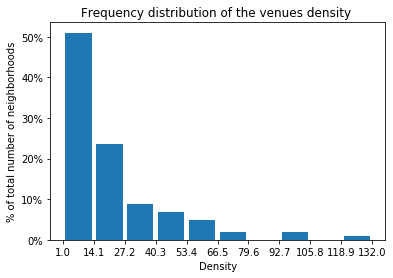

In [114]:
n, bins, patches = plt.hist(toronto_venues_per_hood['Density'], rwidth=0.85, weights=np.ones(len(toronto_venues_per_hood)) / len(toronto_venues_per_hood))
plt.xticks(bins.tolist())
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
print(type(bins))
plt.xlabel('Density')
plt.ylabel('% of total number of neighborhoods')
plt.title('Frequency distribution of the venues density ')
plt.show()

### Most Common Venue Cetegories

#### New York City

In [116]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical 

In [117]:
nyc_onehot.shape

(9915, 428)

In [146]:
def mostCommonVenuesCategories(oneHotEncodedVenuesDf):
    venuesCategoriesFrequency = pd.DataFrame(columns=['Venue Category', 'Number of Venues'])
    venuesCategoriesFrequencySeries = oneHotEncodedVenuesDf.sum(axis=0)
    rowIndex = 0
    for venueCat, venueFreq in venuesCategoriesFrequencySeries.iteritems():
        if (venueCat != 'Neighborhood'):
            venuesCategoriesFrequency.loc[rowIndex,'Venue Category'] = venueCat
            venuesCategoriesFrequency.loc[rowIndex, 'Number of Venues'] = venueFreq
            rowIndex += 1
    venuesCategoriesFrequency = venuesCategoriesFrequency.sort_values(by='Number of Venues', ascending=False).reset_index(drop=True)
    return venuesCategoriesFrequency

In [147]:
nyc_most_common_venue_categories = mostCommonVenuesCategories(nyc_onehot)
nyc_most_common_venue_categories.head()

,Venue Category,Number of Venues
0,Pizza Place,470
1,Coffee Shop,276
2,Italian Restaurant,265
3,Deli / Bodega,263
4,Bakery,245


In [149]:
nyc_top_ten_common_venues = nyc_most_common_venue_categories.head(10)
nyc_top_ten_common_venues

,Venue Category,Number of Venues
0,Pizza Place,470
1,Coffee Shop,276
2,Italian Restaurant,265
3,Deli / Bodega,263
4,Bakery,245
5,Bar,240
6,Chinese Restaurant,238
7,Park,189
8,Café,178
9,Donut Shop,175


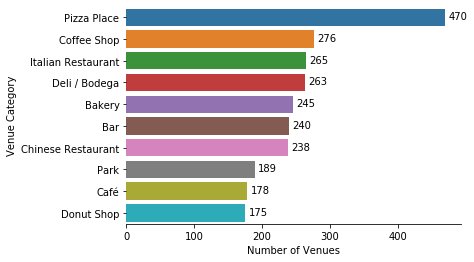

In [207]:
ax1 = sns.barplot(x='Number of Venues', y='Venue Category', data=nyc_top_ten_common_venues)
sns.despine(left = True, bottom = False)
for p in ax1.patches:
    plt.annotate(int(p.get_width()), (p.get_x() + p.get_width() + 5, p.get_y() + 0.5))

#### Toronto

In [203]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Strip Club,Superm

In [204]:
toronto_onehot.shape

(3207, 314)

In [211]:
toronto_most_common_venue_categories = mostCommonVenuesCategories(toronto_onehot)
toronto_most_common_venue_categories.head(10)

,Venue Category,Number of Venues
0,Coffee Shop,256
1,Park,126
2,Pizza Place,114
3,Café,106
4,Restaurant,98
5,Sandwich Place,81
6,Grocery Store,75
7,Bank,73
8,Bakery,73
9,Pharmacy,67


In [212]:
toronto_top_ten_common_venues = toronto_most_common_venue_categories.head(10)

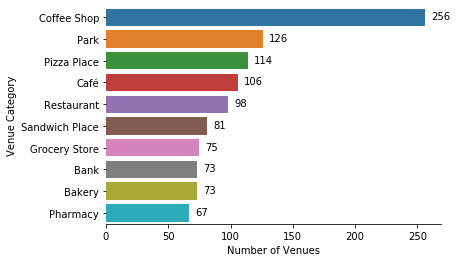

In [213]:
ax2 = sns.barplot(x='Number of Venues', y='Venue Category', data=toronto_top_ten_common_venues)
sns.despine(left = True, bottom = False)
for p in ax2.patches:
    plt.annotate(int(p.get_width()), (p.get_x() + p.get_width() + 5, p.get_y() + 0.5))

### Most idespread Venue Cetegories

#### New York City

In [214]:
nyc_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [250]:
def mostWideSpreadVenuesCategories(city_venues):
    venue_cat_neighborhoods_grouped = city_venues.groupby(['Venue Category', 'Neighborhood']).count().reset_index()
    venue_cat_neighborhoods_grouped = venue_cat_neighborhoods_grouped.groupby(['Venue Category']).count().reset_index()
    city_neighborhoods_of_venue_category = venue_cat_neighborhoods_grouped[['Venue Category', 'Neighborhood']]
    city_neighborhoods_of_venue_category = city_neighborhoods_of_venue_category.rename({'Neighborhood': 'Number of Neighborhoods'}, axis=1)
    city_neighborhoods_of_venue_category = city_neighborhoods_of_venue_category.sort_values(by='Number of Neighborhoods', ascending=False).reset_index(drop=True)
    return city_neighborhoods_of_venue_category

In [251]:
nyc_neighborhoods_of_venue_category = mostWideSpreadVenuesCategories(nyc_venues)
nyc_neighborhoods_of_venue_category.head()

,Venue Category,Number of Neighborhoods
0,Pizza Place,198
1,Deli / Bodega,151
2,Chinese Restaurant,140
3,Donut Shop,128
4,Sandwich Place,128


In [249]:
nyc_neighborhoods_of_venue_category.shape

(427, 2)

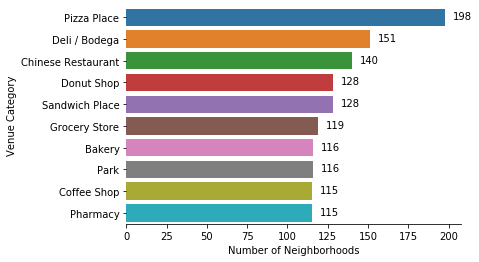

In [253]:
ax3 = sns.barplot(x='Number of Neighborhoods', y='Venue Category', data=nyc_neighborhoods_of_venue_category.head(10))
sns.despine(left = True, bottom = False)
for p in ax3.patches:
    plt.annotate(int(p.get_width()), (p.get_x() + p.get_width() + 5, p.get_y() + 0.5))

#### Toronto

In [254]:
toronto_neighborhoods_of_venue_category = mostWideSpreadVenuesCategories(toronto_venues)
toronto_neighborhoods_of_venue_category.head()

,Venue Category,Number of Neighborhoods
0,Coffee Shop,79
1,Park,70
2,Pizza Place,60
3,Restaurant,58
4,Bank,53


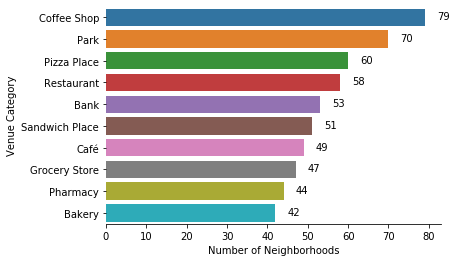

In [257]:
ax4 = sns.barplot(x='Number of Neighborhoods', y='Venue Category', data=toronto_neighborhoods_of_venue_category.head(10))
sns.despine(left = True, bottom = False)
for p in ax4.patches:
    plt.annotate(int(p.get_width()), (p.get_x() + p.get_width() + 3, p.get_y() + 0.5))

## Clustering Neighborhoods

### New York City

In [258]:
nyc_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical 

In [300]:
nyc_grouped = nyc_onehot.groupby(['Neighborhood']).mean().reset_index()
nyc_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical 

In [269]:
k_clusters = 5
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)
kmeans = KMeans(init='k-means++',n_clusters=k_clusters, random_state=0).fit(nyc_grouped_clustering)
kmeans.labels_[0:10] 

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [278]:
# create a new df containing neighborhood, clustering labels, lat and long
NYC_neighborhoods_clusters = nyc_grouped[['Neighborhood']]
for i in range(len(NYC_neighborhoods)):
    for j in range(len(NYC_neighborhoods_clusters)):
        if (NYC_neighborhoods.loc[i, 'Neighborhood'] == NYC_neighborhoods_clusters.loc[j, 'Neighborhood']):
            NYC_neighborhoods_clusters.loc[j,'Latitude'] = NYC_neighborhoods.loc[i,'Latitude']
            NYC_neighborhoods_clusters.loc[j,'Longitude'] = NYC_neighborhoods.loc[i,'Longitude']

NYC_neighborhoods_clusters.insert(3, 'Cluster Labels', kmeans.labels_)
NYC_neighborhoods_clusters.head()

C:\Users\Hassan\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Hassan\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Neighborhood,Latitude,Longitude,Cluster Labels
0,Allerton,40.865788,-73.859319,1
1,Annadale,40.538114,-74.178549,1
2,Arden Heights,40.549286,-74.185887,1
3,Arlington,40.635325,-74.165104,0
4,Arrochar,40.596313,-74.067124,1


In [285]:
# create map
nyc_clusters = folium.Map(location=[NYC_latitude, NYC_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NYC_neighborhoods_clusters['Latitude'], NYC_neighborhoods_clusters['Longitude'], NYC_neighborhoods_clusters['Neighborhood'], NYC_neighborhoods_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(nyc_clusters)
       
nyc_clusters

In [301]:
toronto_grouped = toronto_onehot.groupby(['Neighborhood']).mean().reset_index()
toronto_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Strip Club,Superm

In [281]:
k_clusters = 5
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(init='k-means++',n_clusters=k_clusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10] 

array([2, 2, 3, 2, 2, 0, 2, 2, 2, 3])

In [282]:
# create a new df containing neighborhood, clustering labels, lat and long
toronto_neighborhoods_clusters = toronto_grouped[['Neighborhood']]
for i in range(len(toronto_neighborhoods)):
    for j in range(len(toronto_neighborhoods_clusters)):
        if (toronto_neighborhoods.loc[i, 'Neighborhood'] == toronto_neighborhoods_clusters.loc[j, 'Neighborhood']):
            toronto_neighborhoods_clusters.loc[j,'Latitude'] = toronto_neighborhoods.loc[i,'Latitude']
            toronto_neighborhoods_clusters.loc[j,'Longitude'] = toronto_neighborhoods.loc[i,'Longitude']

toronto_neighborhoods_clusters.insert(3, 'Cluster Labels', kmeans.labels_)
toronto_neighborhoods_clusters.head()

C:\Users\Hassan\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Hassan\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Neighborhood,Latitude,Longitude,Cluster Labels
0,Agincourt,43.794200,-79.262029,2
1,"Alderwood, Long Branch",43.602414,-79.543484,2
2,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,3
3,Bayview Village,43.786947,-79.385975,2
4,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,2


In [283]:
# create map
toronto_clusters = folium.Map(location=[TO_latitude, TO_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_neighborhoods_clusters['Latitude'], toronto_neighborhoods_clusters['Longitude'], toronto_neighborhoods_clusters['Neighborhood'], toronto_neighborhoods_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toronto_clusters)
       
toronto_clusters

### nyc & toronto data combining

In [302]:
nyc_grouped_modified_hood = nyc_grouped.copy()
nyc_grouped_modified_hood.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical 

In [303]:
toronto_grouped_modified_hood = toronto_grouped.copy()
toronto_grouped_modified_hood.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Strip Club,Superm

In [304]:
nyc_grouped_modified_hood['Neighborhood'] = nyc_grouped_modified_hood['Neighborhood'].astype(str) + '-nyc'
toronto_grouped_modified_hood['Neighborhood'] = toronto_grouped_modified_hood['Neighborhood'].astype(str) + '-to'

In [305]:
nyc_grouped_modified_hood.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical 

In [311]:
nyc_grouped_modified_hood.shape

(302, 428)

In [307]:
toronto_grouped_modified_hood.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Strip Club,Superm

In [312]:
toronto_grouped_modified_hood.shape

(102, 314)

### combine the two dataframes

In [308]:
nyc_to_grouped = pd.concat([nyc_grouped_modified_hood,toronto_grouped_modified_hood], axis=0, ignore_index=True)

In [310]:
nyc_to_grouped.shape

(404, 462)

In [317]:
nyc_to_grouped.loc[298:303, :]

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical 

#### replace NaN with zero

In [318]:
nyc_to_grouped = nyc_to_grouped.fillna(0)

In [319]:
nyc_to_grouped.loc[298:303, :]

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical 

### find optimum number of clusters for K-means clustering method

In [461]:
def findOptimumK(city_grouped_df):
    distortions = []
    cluster_numbers = range(1,10)
    city_grouped_df_clustering = city_grouped_df.drop('Neighborhood', 1)
    for k in cluster_numbers:
        kmeans = KMeans(init='k-means++',n_clusters=k, random_state=0).fit(city_grouped_df_clustering)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(16,8))
    plt.plot(cluster_numbers, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

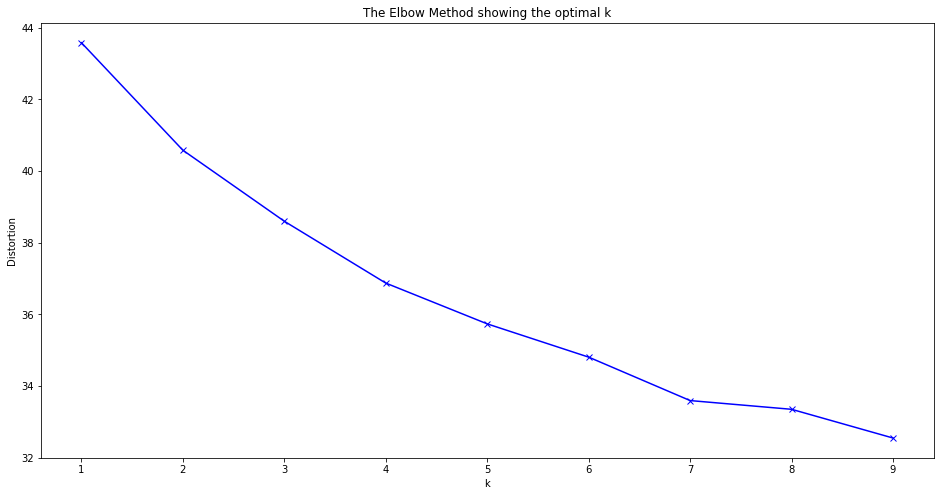

In [462]:
findOptimumK(nyc_to_grouped)

#### based on the elbow method, the optimum number of clusters is 7

In [331]:
k_clusters = 7
nyc_to_grouped_clustering = nyc_to_grouped.drop('Neighborhood', 1)
kmeans = KMeans(init='k-means++',n_clusters=k_clusters, random_state=0).fit(nyc_to_grouped_clustering)
kmeans.labels_[0:10]

array([4, 0, 4, 0, 0, 0, 0, 0, 0, 4])

In [332]:
nyc_to_grouped_clusters = nyc_to_grouped.copy()
nyc_to_grouped_clusters.insert(1, 'Cluster Labels', kmeans.labels_)

In [333]:
nyc_to_grouped_clusters.head()

,Neighborhood,Cluster Labels,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Opera

In [334]:
nyc_to_grouped_clusters.groupby(['Cluster Labels']).count()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical 

#### create a dataframe for each cluster

In [380]:
# clusterNums = list(range(1, 8))
def venueCatPercentForAClusterNumber(combined_cities_clusters, clusNum):
    rowsToBeremoved = []    
    for rowIndex in range(len(combined_cities_clusters)):
        if (combined_cities_clusters.loc[rowIndex, 'Cluster Labels'] != clusNum-1):
            rowsToBeremoved.append(rowIndex)
    
    clusterDf = combined_cities_clusters.copy()
    clusterDf = clusterDf.drop(['Cluster Labels'], axis=1)
    clusterDf = clusterDf.drop(rowsToBeremoved)
    venuesNumberPerCat = mostCommonVenuesCategories(clusterDf)
    venuesPercentPerCat = venuesNumberPerCat.copy()
    venuesPercentPerCat['Number of Venues'] = venuesPercentPerCat['Number of Venues']/len(clusterDf) *100
    venuesPercentPerCat = venuesPercentPerCat.rename(columns={"Number of Venues": "% of Venues"})
    return venuesPercentPerCat

### Cluster One

In [381]:
cluster_one = venueCatPercentForAClusterNumber(nyc_to_grouped_clusters, 1)
cluster_one.head()

,Venue Category,% of Venues
0,Coffee Shop,3.65207
1,Park,2.86153
2,Deli / Bodega,2.71033
3,Pizza Place,2.59208
4,Italian Restaurant,2.55749


### Cluster Two

In [384]:
cluster_two = venueCatPercentForAClusterNumber(nyc_to_grouped_clusters, 2)
cluster_two.head()

,Venue Category,% of Venues
0,Park,47.7976
1,Trail,7.61905
2,Coffee Shop,5
3,Beach,3.57143
4,Hotel,3.57143


### Cluster Three

In [385]:
cluster_three = venueCatPercentForAClusterNumber(nyc_to_grouped_clusters, 3)
cluster_three.head()

,Venue Category,% of Venues
0,Deli / Bodega,70.8333
1,Market,12.5
2,Pharmacy,8.33333
3,Spanish Restaurant,8.33333
4,Plaza,0


### Cluster Four

In [386]:
cluster_four = venueCatPercentForAClusterNumber(nyc_to_grouped_clusters, 4)
cluster_four.head()

,Venue Category,% of Venues
0,Construction & Landscaping,100
1,ATM,0
2,Pizza Place,0
3,Puerto Rican Restaurant,0
4,Public Art,0


### Cluster Five

In [387]:
cluster_five = venueCatPercentForAClusterNumber(nyc_to_grouped_clusters, 5)
cluster_five.head()

,Venue Category,% of Venues
0,Pizza Place,13.3041
1,Pharmacy,4.07363
2,Bank,4.03491
3,Grocery Store,3.39211
4,Deli / Bodega,3.29925


### Cluster Six

In [388]:
cluster_six = venueCatPercentForAClusterNumber(nyc_to_grouped_clusters, 6)
cluster_six.head()

,Venue Category,% of Venues
0,Boat or Ferry,100
1,ATM,0
2,Pizza Place,0
3,Puerto Rican Restaurant,0
4,Public Art,0


### Cluster Seven

In [389]:
cluster_seven = venueCatPercentForAClusterNumber(nyc_to_grouped_clusters, 7)
cluster_seven.head()

,Venue Category,% of Venues
0,Beach,100
1,ATM,0
2,Playground,0
3,Puerto Rican Restaurant,0
4,Public Art,0


In [407]:
def numberOfHoodsOfCitiesInCluster(combined_cities_clusters, clusNum):
    rowsToBeremoved = []    
    for rowIndex in range(len(combined_cities_clusters)):
        if (combined_cities_clusters.loc[rowIndex, 'Cluster Labels'] != clusNum-1):
            rowsToBeremoved.append(rowIndex)
    
    clusterDf = combined_cities_clusters.copy()
    clusterDf = clusterDf.drop(['Cluster Labels'], axis=1)
    clusterDf = clusterDf.drop(rowsToBeremoved)
    nycClusterDf = clusterDf.copy()
    nycClusterDf = nycClusterDf[nycClusterDf['Neighborhood'].str.contains('nyc', regex=False)]
    
    clustNumPerCity = pd.DataFrame({'city': ['NYC', 'Toronto'], 'cluster No.': [clusNum, clusNum]}, columns=['cluster No.', 'city', 'number of neighborhoods'])
    clustNumPerCity.loc[0, 'number of neighborhoods'] = len(nycClusterDf)
    clustNumPerCity.loc[1, 'number of neighborhoods'] = len(clusterDf) - len(nycClusterDf)
    return clustNumPerCity

In [400]:
numberOfHoodsOfCityInCluster(nyc_to_grouped_clusters, 1)

,cluster No.,city,number of neighborhoods
0,1,NYC,216
1,1,Toronto,81


In [423]:
def numberOfHoodsOfCitiesInAllClusters(combined_cities_clusters):
    allClusters = []
    for clusNum in range(1,8):
        clusNumDf = numberOfHoodsOfCitiesInCluster(combined_cities_clusters, clusNum)
        allClusters.append(clusNumDf)
    
    clusterPerCityHoodsNum = pd.concat(allClusters)
    return clusterPerCityHoodsNum

In [425]:
hoodsNumPerCityInCluster = numberOfHoodsOfCitiesInAllClusters(nyc_to_grouped_clusters)
hoodsNumPerCityInCluster

,cluster No.,city,number of neighborhoods
0,1,NYC,216
1,1,Toronto,81
0,2,NYC,8
1,2,Toronto,6
0,3,NYC,4
1,3,Toronto,0
0,4,NYC,1
1,4,Toronto,0
0,5,NYC,70
1,5,Toronto,15


[(0, 250)]

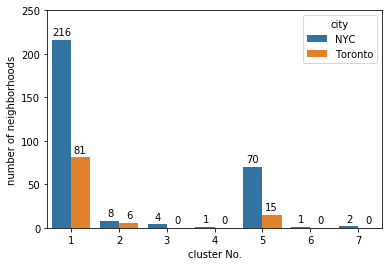

In [457]:
ax = sns.barplot(x='cluster No.', y='number of neighborhoods', hue='city', data=hoodsNumPerCityInCluster)
for p in ax.patches:
    if (int(p.get_height()) <10):
        plt.annotate(int(p.get_height()), (p.get_x() + 0.15 , p.get_height() + 5))
    elif (int(p.get_height()) <100):
        plt.annotate(int(p.get_height()), (p.get_x() + 0.05 , p.get_height() + 5))
    else:
        plt.annotate(int(p.get_height()), (p.get_x() , p.get_height() + 5))
ax.set(ylim=(0, 250))